In [1]:
cd /content/drive/MyDrive/Colab Notebooks/동서발전 태양광 발전량 예측 AI 경진대회 태양광 | 한국동서발전(주) | 개인 스타트업 | 시계열 | NMAE/data

/content/drive/MyDrive/Colab Notebooks/동서발전 태양광 발전량 예측 AI 경진대회 태양광 | 한국동서발전(주) | 개인 스타트업 | 시계열 | NMAE/data


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

In [32]:
energy = pd.read_csv('energy.csv')
dangjin_fcst = pd.read_csv('dangjin_fcst_data.csv')
ulsan_fcst = pd.read_csv('ulsan_fcst_data.csv')

In [33]:
energy.head()

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2018-03-01 1:00:00,0.0,0.0,0,0
1,2018-03-01 2:00:00,0.0,0.0,0,0
2,2018-03-01 3:00:00,0.0,0.0,0,0
3,2018-03-01 4:00:00,0.0,0.0,0,0
4,2018-03-01 5:00:00,0.0,0.0,0,0


In [34]:
dangjin_fcst.head()

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-01 11:00:00,4.0,0.0,60.0,7.3,309.0,2.0
1,2018-03-01 11:00:00,7.0,-2.0,60.0,7.1,314.0,1.0
2,2018-03-01 11:00:00,10.0,-2.0,60.0,6.7,323.0,1.0
3,2018-03-01 11:00:00,13.0,-2.0,55.0,6.7,336.0,1.0
4,2018-03-01 11:00:00,16.0,-4.0,55.0,5.5,339.0,1.0


In [35]:
ulsan_fcst.head()

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-01 11:00:00,4.0,8.0,20.0,14.0,298.0,2.0
1,2018-03-01 11:00:00,7.0,4.0,20.0,4.3,298.0,2.0
2,2018-03-01 11:00:00,10.0,3.0,30.0,1.9,309.0,2.0
3,2018-03-01 11:00:00,13.0,0.0,40.0,1.5,318.0,2.0
4,2018-03-01 11:00:00,16.0,-1.0,45.0,1.8,308.0,2.0


In [36]:
dangjin_fcst['Forecast_time'] = pd.to_datetime(dangjin_fcst['Forecast time'])
ulsan_fcst['Forecast_time'] = pd.to_datetime(ulsan_fcst['Forecast time'])

In [37]:
dangjin_fcst_14 = dangjin_fcst[dangjin_fcst['Forecast_time'].dt.hour==14]
ulsan_fcst_14 = ulsan_fcst[ulsan_fcst['Forecast_time'].dt.hour==14]

In [38]:
dangjin_fcst_14 = dangjin_fcst_14[(dangjin_fcst_14['forecast']>=10)&(dangjin_fcst_14['forecast']<=33)]
ulsan_fcst_14 = ulsan_fcst_14[(ulsan_fcst_14['forecast']>=10)&(ulsan_fcst_14['forecast']<=33)]

In [39]:
def to_date(x):
    return pd.DateOffset(hours=x)

dangjin_fcst_14['Forecast_time'] = dangjin_fcst_14['Forecast_time'] + dangjin_fcst_14['forecast'].map(to_date)
ulsan_fcst_14['Forecast_time'] = ulsan_fcst_14['Forecast_time'] + ulsan_fcst_14['forecast'].map(to_date)

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimelike.py:1345: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,


In [40]:
dangjin_fcst_14 = dangjin_fcst_14[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
ulsan_fcst_14 = ulsan_fcst_14[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]

In [41]:
dangjin_fcst_14_ = pd.DataFrame()
dangjin_fcst_14_['Forecast_time'] = pd.date_range(start='2018-03-02 00:00:00', end='2021-03-01 23:00:00', freq='H')

ulsan_fcst_14_ = pd.DataFrame()
ulsan_fcst_14_['Forecast_time'] = pd.date_range(start='2018-03-02 00:00:00', end='2021-03-01 23:00:00', freq='H')

In [42]:
dangjin_fcst_14_ = pd.merge(dangjin_fcst_14_, dangjin_fcst_14, on='Forecast_time', how='outer')
ulsan_fcst_14_ = pd.merge(ulsan_fcst_14_, ulsan_fcst_14, on='Forecast_time', how='outer')

In [43]:
dangjin_fcst = dangjin_fcst_14_.interpolate()
ulsan_fcst = ulsan_fcst_14_.interpolate()

In [45]:
dangjin_fcst['Forecast_time'] = dangjin_fcst['Forecast_time'].astype(str)
ulsan_fcst['Forecast_time'] = ulsan_fcst['Forecast_time'].astype(str)

In [46]:
dangjin_fcst.head()

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-02 00:00:00,-2.000000,55.000000,6.7,336.000000,1.0
1,2018-03-02 01:00:00,-2.666667,55.000000,6.3,337.000000,1.0
2,2018-03-02 02:00:00,-3.333333,55.000000,5.9,338.000000,1.0
3,2018-03-02 03:00:00,-4.000000,55.000000,5.5,339.000000,1.0
4,2018-03-02 04:00:00,-4.333333,56.666667,5.1,340.666667,1.0


In [47]:
ulsan_fcst.head()

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-02 00:00:00,0.000000,40.000000,1.500000,318.000000,2.000000
1,2018-03-02 01:00:00,-0.333333,41.666667,1.600000,314.666667,2.000000
2,2018-03-02 02:00:00,-0.666667,43.333333,1.700000,311.333333,2.000000
3,2018-03-02 03:00:00,-1.000000,45.000000,1.800000,308.000000,2.000000
4,2018-03-02 04:00:00,-1.333333,45.000000,1.766667,303.333333,1.666667


In [48]:
def train_datast(energy_df, fcst_df, target):
    # 일기 예보 있는 날짜만 선택
    energy = energy_df.loc[24:]
    energy.index = range(energy.shape[0])
    
    # 발전량 데이터가 있는 날짜만 선택
    fcst = fcst_df.loc[:25608-1]
    fcst.index = range(fcst.shape[0])
    
    # 발전량과 일기예보 연결
    concat_df = pd.concat([energy, fcst], axis=1)
    
    # 예보 시간 및 날짜 정보 feature로 추가
    concat_df['date'] = concat_df['Forecast_time'].str.split(' ').str[0]
    concat_df['hour'] = concat_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    concat_df['year'] = concat_df['date'].str.split('-').str[0].astype(int)
    concat_df['month'] = concat_df['date'].str.split('-').str[1].astype(int)
    concat_df['day'] = concat_df['date'].str.split('-').str[2].astype(int)
    
    # 예보 시간, 날짜, 기상 예보 및 발전량 선택
    feature_df = concat_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud', target]]
    
    # 마지막 30일을 검증데이터셋으로 나머지를 학습 데이터셋으로 선택
    train_df = feature_df.iloc[:-24*30]
    val_df = feature_df.iloc[-24*30:]
    
    # 발전량이 0인 데이터를 제외
    train_df = train_df[train_df[target]!=0]
    
    train_x = train_df.loc[:, 'year':'Cloud'].to_numpy()
    train_y = train_df[target].to_numpy()
    
    val_x = val_df.loc[:, 'year':'Cloud'].to_numpy()
    val_y = val_df[target].to_numpy()
    
    return train_x, train_y, val_x, val_y

LightGBM Custom Metric

In [49]:
def nmae_10(y_pred, dataset):
    y_true = dataset.get_label()
    
    absolute_error = abs(y_true - y_pred)
    absolute_error /= capacity
    
    target_idx = np.where(y_true>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return 'score', nmae, False

Validation Metric

In [50]:
def sola_nmae(answer, pred):
    absolute_error = np.abs(answer - pred)
    
    absolute_error /= capacity
    
    target_idx = np.where(answer>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return nmae

LightGBM Hyperparameter

In [69]:
params = {
    'learning_rate': 0.01,
    'objective': 'regression',
    'metric':'mae',
    'seed':64
}

당진수상태양광 예측 모델 학습

In [78]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_fcst, target='dangjin_floating')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 5050
dangjin_floating_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid_0's l1: 82.7792	valid_0's score: 10.5753


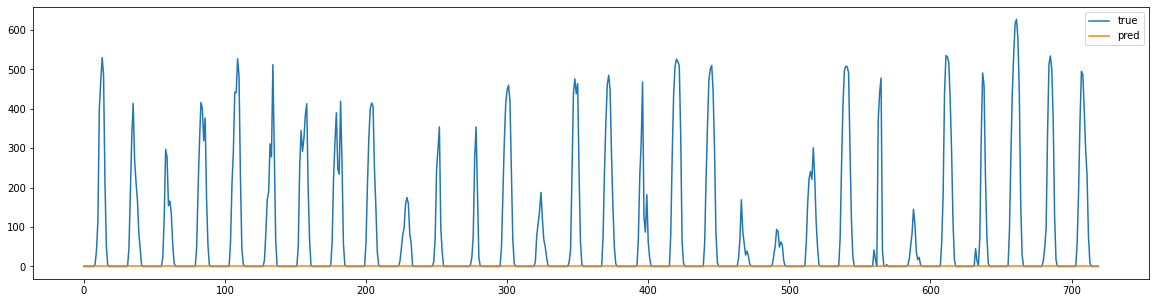

CV Score :  10.575299635226683


In [79]:
pred = dangjin_floating_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

In [ ]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_fcst, target='dangjin_warehouse')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 700
dangjin_warehouse_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

In [ ]:
pred = dangjin_warehouse_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

In [124]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_fcst, target='dangjin')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 1000
dangjin_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[230]	valid_0's l1: 55.3252	valid_0's score: 9.82137


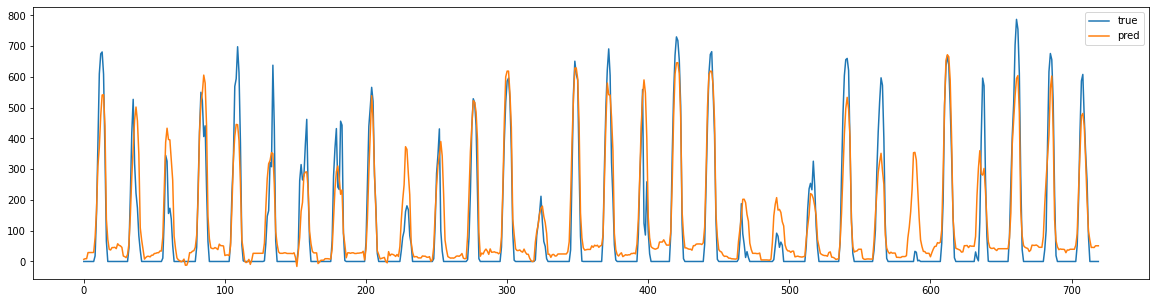

CV Score :  9.821369379229926


In [125]:
pred = dangjin_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

울산태양광예측모델학습

In [126]:
train_x, train_y, val_x, val_y = train_datast(energy, ulsan_fcst, target='ulsan')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 500
ulsan_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[281]	valid_0's l1: 15.9037	valid_0's score: 6.31869


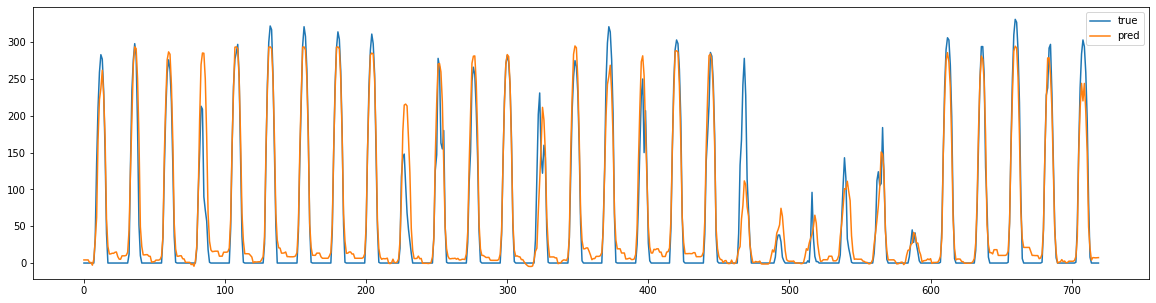

CV Score :  6.318693552151994


In [127]:
pred = ulsan_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

테스트 데이터 전처리

In [128]:
def test_datast(fcst_df):
    start = '2021-02-01 00:00:00'
    end = '2021-02-28 23:00:00'
    
    start_idx = fcst_df[fcst_df['Forecast_time']==start].index[0]
    end_idx = fcst_df[fcst_df['Forecast_time']==end].index[0]
    
    test_df = fcst_df.loc[start_idx:end_idx, :].copy()
    
    test_df['date'] = test_df['Forecast_time'].str.split(' ').str[0]
    test_df['hour'] = test_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    test_df['year'] = test_df['date'].str.split('-').str[0].astype(int)
    test_df['month'] = test_df['date'].str.split('-').str[1].astype(int)
    test_df['day'] = test_df['date'].str.split('-').str[2].astype(int)
    
    test_df = test_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
    
    test_x = test_df.to_numpy()
    
    return test_x

In [129]:
dangjin_test = test_datast(dangjin_fcst)
ulsan_test = test_datast(ulsan_fcst)

발전량 추론

In [130]:
dangjin_floating_pred = dangjin_floating_model.predict(dangjin_test)
dangjin_warehouse_pred = dangjin_warehouse_model.predict(dangjin_test)
dangjin_pred = dangjin_model.predict(dangjin_test)
ulsan_pred = ulsan_model.predict(ulsan_test)

NameError: ignored

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(dangjin_floating_pred, label = 'dangjin_floating_pred')
plt.plot(dangjin_warehouse_pred, label = 'dangjin_warehouse_pred')
plt.plot(dangjin_pred, label = 'dangjin_pred')
plt.plot(ulsan_pred, label = 'ulsan_pred')
plt.legend()
plt.show()

In [ ]:
submission = pd.read_csv('/sample_submission.csv')

In [ ]:
submission.iloc[:24*28, 1] = dangjin_floating_pred
submission.iloc[:24*28, 2] = dangjin_warehouse_pred
submission.iloc[:24*28, 3] = dangjin_pred
submission.iloc[:24*28, 4] = ulsan_pred

In [ ]:
submission

In [ ]:
submission.to_csv('dacon_baseline.csv', index=False)